In [3]:
def GibbsSampler (Dna, kmer_length, iterations):
    """Input 1: list with strings corresponding to dna sequences/motifs
       Input 2: int corresponding to kmers' length (N of bases at each one)
       Input 3: int 
       
       1) Generate a random list of kmers from a list of dna sequences/Motifs
       2) Remove one kmer randomly from the list 
       3) Generate a probability profile based on the remaining ones
       4) Calculate normalized probabilities for all kmers in the motif the kmer of which was 'removed'. 
          (Quotes because we only remove the kmer from the kmer list, not from the Dna list.)
       5) Randomly, yet based on previously calculated normalized probabilities for each kmer, select a kmer by rolling a weighed die
       6) Create a shallow copy list of kmers and append the randomly chosen kmer to its respective position in kmers list.
       7) Calculate the score (total number of bases different than that of the consensus string in each position) for the shallow copy
          and compare it with the score of the already existing kmers (that is the score before removing one kmer)
       8) If the score of the modified shallow copy is smaller than that of the already existing kmers, replace the second with the first.
       9) Repeat starting from step 2
    """
    import random
    N_of_motifs = len(Dna)
    kmers = Random_kmers (Dna, kmer_length)
    
    for i in range(iterations) :
        existing_kmers_score    = Score(Count(kmers))                                                                        #Score takes a dic which is output of Count() as an argument
        exclusion_index         = random.randint(0,N_of_motifs-1) 
        excluded_kmer           = kmers.pop(exclusion_index)                                                                 # Dna and kmers have the same indexing, N motifs = N kmers
        kmers_minus_one_profile = Profile(CountWithPseudocounts(kmers))                                                      # generate profile based on remaining kmers
        prob_kmer_from_excld_motif = ProfileGeneratedString(Dna[exclusion_index],kmers_minus_one_profile, kmer_length)       # Dna[exclusion_index] indicates motif of which kmer was 'removed' in kmer list. Rolling a weighed die       
        new_kmers               = kmers[:]                                                                                   # shallow copy to avoid appending directly to kmers 
        new_kmers.insert(exclusion_index, prob_kmer_from_excld_motif)                                                        # new kmer in the place of previously removed

        
        if Score(Count(new_kmers)) < existing_kmers_score:
            kmers = new_kmers
        else :
            kmers.insert(exclusion_index,excluded_kmer)                                                                      #place removed kmer back
    

    return kmers


# The first 100 iterations suffice to come up with a low score. Notably, even if we iterate thousands of times, the score will most likely 'get stuck' at a number within the first 100 iterations, for the rest N of iterations.  


In [4]:
def RandomizedMotifSearch (Dna,kmer_length):
    """Input 1: List with str (motifs) as elements
       Input 2: int corresponding to the length of kmers (number of bases) that we are going to select
       Output : List with str (kmers) as elements.
       
       1) Start by randomly selecting kmers from a Dna list 
       2) Create a profile based on kmers
       3) Find kmers within the Dna list based on this profile
       4) If kmers' score is smaller(better) than the previous, keep these kmers
       5) Repeat from step 2 and so on and so forth 
       
          This function should be iterated in a for loop for better results. It can find longer motifs in shorter time. 
          """
    
    Bestkmers = Random_kmers(Dna,kmer_length)                           
    
    while True:                                                                         
        profile = Profile(CountWithPseudocounts(Bestkmers))                 # we need a dictionary of counts as a Profile() input
        new_profile_based_kmers = Motifs(profile, Dna,kmer_length)          ## pseudocounts added to select a more accurate most probable kmer for each motif                             
        
        if Score(Count(new_profile_based_kmers)) < Score(Count(Bestkmers)): # we need a dictionary of counts as a Score() input. No pseudocounts are applied in calculation of score
            Bestkmers = new_profile_based_kmers
        else:
            return Bestkmers
    

In [5]:
def Greedy_Motifs_With_Pseudocounts (sequences, kmer_length):
    """Input 1: list with strings(dna sequences/Motifs) as elements
       Input 2: int corresponding to the length of kmers we want to search for within the sequences
       Output : list with strings (kmers) as elements
       
       1) Create a profile score based on the first (0:0+kmer_length) kmer of the first list in sequences.
          Append the (0:kmer_length) to a separate list (iteration_selected_motifs). 
       2) Search for the most probable kmer in the second list in sequences based on the previously created profile score.
          If there is no such kmer (p=0), append (0:kmer_length) kmer to the iteration_selected_motifs.
          If there is such kmer, append its respective starting index to the iteration_selected_motifs.
       3) Reconstruct the profile score taking into account the 2nd kmer too.
       4) Search for the most probable kmer in the third list in sequences based on the previously created profile score.
          If there is no such kmer (p=0), append (0:kmer_length) kmer to the iteration_selected_motifs.
          If there is such kmer, append its respective starting index to the iteration_selected_motifs  and so on and so forth.
       5) When the set of most probable kmers is completed, calculate their overall score (diviation from consensus string)
          If the overall score is the lower so far, replace the bestscore with the current and save the BestMotifs
       6) Repeat step 1 by replacing (0:kmer_length) kmer with (1:1+kmer_length) kmer and so on and so forth until n-kmer_length+1"""
          
    
    
    N_of_kmers = len(sequences)
    N_of_bases = len(sequences[0])
    BestMotifs = []
    BestScore = 0
    bank = []
    
    for sequence_index in range(N_of_kmers):                                                 # initiate BestMotifs
        BestMotifs.append(sequences[sequence_index][0:kmer_length])
    
    BestScore = Score(CountWithPseudocounts(BestMotifs))                                     #consensus_string() embedded in Score() can be simplified for better timeit() if not interested in random pick of consensus str   
    
    for kmer_index in range(N_of_bases - kmer_length + 1) :
        basic_kmer = [sequences[0][kmer_index:kmer_index+kmer_length]]                       #in form of list to match Count() input       
        iteration_selected_motifs= basic_kmer [:]
        dynamic_prof = Profile(CountWithPseudocounts(iteration_selected_motifs))
        
        for sequence_index in range(1,N_of_kmers):
            sequence = sequences[sequence_index]
            most_probable_kmer = Most_Prob_Kmer(dynamic_prof,sequence,kmer_length)
            
            if most_probable_kmer != False :                                                 #False when p for all kmers is 0
                 iteration_selected_motifs.append(most_probable_kmer)
            else : 
                 iteration_selected_motifs.append(sequences[sequence_index][0:kmer_length])  # 1st kmer in sequence as default most probable kmer  
            
            dynamic_prof = Profile(CountWithPseudocounts(iteration_selected_motifs))    
        
        new_score = Score(CountWithPseudocounts(iteration_selected_motifs))
        bank.append(new_score)
        
        if new_score < BestScore :
            BestScore = new_score
            BestMotifs = iteration_selected_motifs
    
    occ = bank.count(min(bank))
    if occ > 1:
        occ_indexes = [index for index in range(len(bank)) if bank[index] == min(bank)]                        
        print ('There are {} BestMotif sets of equivalent minumum score'.format(occ))
        print ('BestMotifs can be found by iterations at indexes {}'.format(occ_indexes))
        print ('Only the first occurence of BestMotifs set will be returned')
    
    return BestMotifs  

In [6]:
def ProfileGeneratedString(sequence, profile, kmer_length):
    """Input 1: string
       Input 2: Dictionary with kmers as keys and probabilities as values (int). 
       Input 3: int corresponding to kmers' length (N of bases at each one)
       Output : str corresponding to a randomly selected kmer based on probability weighs
       
       Submits all possible kmers of a short dna sequence/Motif to a dictionary as keys. 
       Calculates probabilities for each kmer and then normalizes these probabilties and returns a single kmer.
       The selection of kmer is done randomly, yet based on the normalized probabilities as weights (WeightedDie)"""
    
    probabilities = {}
    
    for index in range(0,len(sequence)-kmer_length+1):
        probabilities[sequence[index:index+kmer_length]] = Profile_Based_Prob(sequence[index:index+kmer_length], profile)
    probabilities = Normalize_Probabilities(probabilities)
    
    
    return WeightedDie(probabilities)

#### Generate profile matrices based on  different kmers

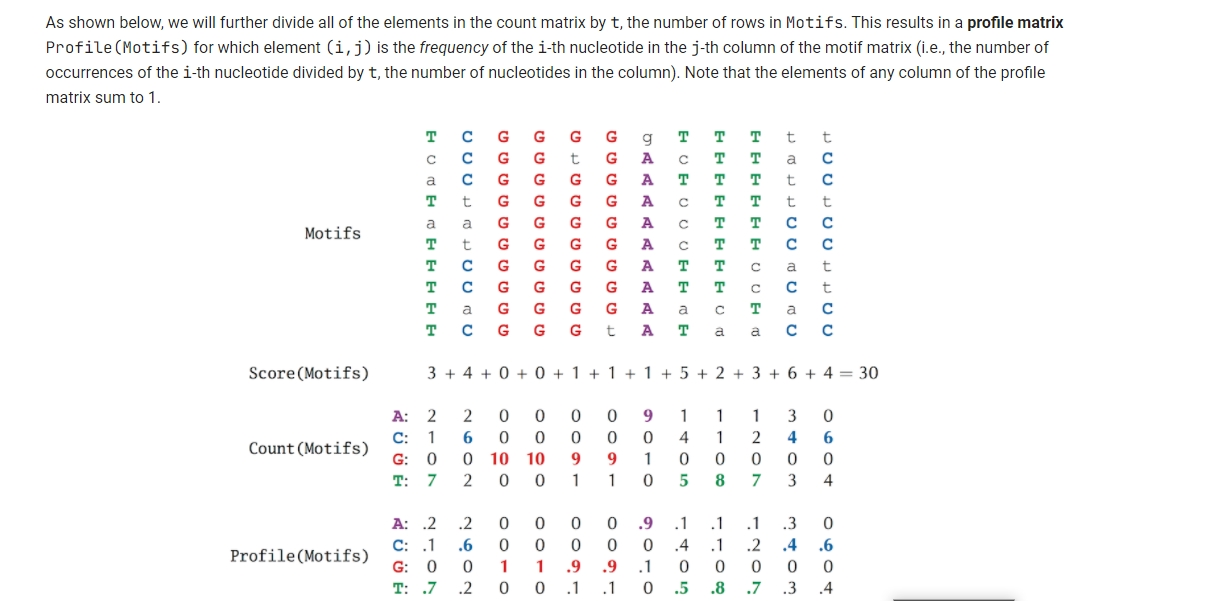

In [7]:
def Count(Motifs):
    """Input : list with motifs (kmers that might be slightly different) in the form of strings 
       Output: Dictionary with 4 dna bases as keys and lists as values. Elements of lists are integers that correspond to the
               times each key appears in a specific position among all kmers"""
    
    list_length  = len(Motifs)
    kmer_length = len(Motifs[0])                         # can insert any index since all string elements in the list are of equal length
    count = {}                                           # initializing the count dictionary
    
    for symbol in "ACGT":                            
        count[symbol] = [0]*kmer_length
        
    for lista_index in range(list_length):
        for kmer_index in range(kmer_length):
            symbol = Motifs[lista_index][kmer_index]     # Motifs [string element index][character index in string element]
            count[symbol][kmer_index] += 1
    return count

In [8]:
def Profile(count):
    """Input : Dictionary, the output of Count(Motifs) 
       Output: Dictionary with 4 dna bases as keys and lists as values. Elements of lists are the integers of the input dic, 
               normalized by the number of motifs (kmers) that were taken into account"""
    
    kmer_length  = len(count['A'])
    N_of_Motifs = (count['A'][0] + count['C'][0] + count['G'][0] + count['T'][0])    # sum of any column = total number of motifs
    
    for key in count:
        normalized = []
        for number in count[key]:
            normalized.append(number/N_of_Motifs)
        count[key] = normalized
        
    return count
        


In [9]:
def Consensus_String (count):
    """Input : Dictionary with 4 dna bases as keys and lists as values. Elements of lists are integers that correspond to the
               times each key appears in a specific position among all kmers
       Output: List with one or more consensus strings. A consensus string comprises the DNA base with the 
               largest frequency for every single position(index), taking into account all kmers.
               
               Creates a default consensus string (mask) where bases are replaced with 'x' in ambiguous positions.
               Ambiguous positions are indexes where there are more than one maximum frequent bases (same number)
               Calculates all possible combinations between the dna bases that correspond to ambiguous positions. 
               Uses the default consensus string to replace the ambiguous 'x' positions with the bases of each possible combinations
               * For better timeit() results, this function can be easily replaced by one returning only one consensus string"""

    import itertools

    kmer_length = len(count['A'])
    mask = ""                                                   # create a string that will pass its no-'x' values to all possible combs of 
    alternatives = []

    for index in range(kmer_length) :
        lista = []                                              # List with tuples (value,base) for each index across kmers' length
        lista.append ((count['A'][index],'A'))
        lista.append ((count['C'][index],'C'))
        lista.append ((count['G'][index],'G'))
        lista.append ((count['T'][index],'T'))

        most_freq_letter = lista.pop(lista.index(max(lista)))   # pop the tuple to search for remaining equivalent values in the lista
        mask += most_freq_letter[1]                             # append base from (value,base)

        tuples = ()                                             # bases with equal values to most_freq_letter[1] will be added here
        for tup in lista :
            if tup[0] == most_freq_letter[0]:                   # if a value of another base is the same as that of the most frequent base for this index
                tuples += tuple(tup[1])                         # insert the respective base in a collection of bases (tuples) for this index position

        if len(tuples) > 0 :                                    # true when there is at least a 2nd base with same value
            tuples += tuple(mask[-1])                           # insert the most_freq_letter[1] base too, to be able to calculate all possible combs later on
            alternatives.append(tuples)                         # list with bases of same values for ALL indexes. Elements are tuples
            mask = mask [:-1] + 'x'                             # if there are more than one prominent bases, mask position with 'x', that is ambiguous position
    
    if 'x' not in mask:                                         # no alternative versions, only one final consensus string
        return [mask]

    else :                                            
        restore_mask = mask                           
        all_tups = list(itertools.product(*alternatives))       #  all possible combs of dna bases in ambiguous positions, note that
        final_consensus_strings =[]                             ## .product takes into account the priority of the list's tuples (indexing)
                                                                ### that's why the created combs are realistic in this case
        for tup in all_tups :                                   # each tup has as many bases as the x positions of a mask and constitutes a unique comb of ambiguous bases
            tup = list(tup)                                     
            for tup_index in range(len(tup)) :
                 mask = mask.replace('x',tup[tup_index],1)      # 1 as an arg, to replace only one and not all x. Then use next base to replace next x, until all x are replaced by all bases
            final_consensus_strings.append(mask)                
            mask = restore_mask

        return final_consensus_strings

In [10]:
def Score(count):
    """ Input : Dictionary with 4 dna bases as keys and lists as values. Elements of lists are integers that correspond to the
               times each key appears in a specific position among all kmers
               
        Output: int that represents the overall occurance of bases differing from consensus string"""
    
    consensus_string = Consensus_String (count) [0]
    kmer_length = len (count['A'])
    total_bases = count['A'][0]+count['C'][0]+count['G'][0]+count['T'][0]
    total_score = 0
    
    for index in range(kmer_length):
        dic_key = count[consensus_string[index]]
        diff = total_bases - dic_key[index]
        total_score += diff
        
    return total_score

In [11]:
def Profile_Based_Prob (kmer,profile) :
    """ Input 1: kmer 
        Input 2: Dictionary with 4 dna bases as keys and lists as values. Elements of lists are the integers corresponding to 
                 N of each base's occurence in each position (index) of kmer, normalized by the number of motifs (kmers) 
                 that were taken into account
         Output: int representing the probability that a kmer occurs based on a profile of probabilities (that is, input 2)"""
    
    pr = 1
    
    for index in range(len(kmer)) :
        base = kmer[index]
        pr *= profile[base][index]
    
    return pr   

In [12]:
def Most_Prob_Kmer (profile, sequence, n):
    """Input 1: Dictionary with 4 dna bases as keys and lists as values. Elements of lists are the integers corresponding to 
                 N of each base's occurence in each position (index) of kmer, normalized by the number of motifs (kmers) 
                 that were taken into account
       Input 2:  str 
       Input 3:  int representing length of kmers to be searched
       Output:   str corresponding to the most probable kmer
       
       Find possible kmers via a naive algorithm and determine their probability to occur based on a profile probability matrix"""
    
    max_pr = [False,0]
    
    for index in range(len(sequence)-n+1):
        kmer = sequence[index:index+n]
        pr = Profile_Based_Prob (kmer,profile)
        
        if pr > max_pr[1] :
            max_pr = [kmer,pr]
    
    return max_pr[0]

In [13]:
def Greedy_Motifs (sequences, kmer_length):                                 
    """Input 1: list with strings(dna sequences/Motifs) as elements
       Input 2: int corresponding to the length of kmers we want to search for within the sequences
       Output : list with strings (kmers) as elements
       
       1) Create a profile score based on the first (0:0+kmer_length) kmer of the first list in sequences.
          Append the (0:kmer_length) to a separate list (iteration_selected_motifs). 
       2) Search for the most probable kmer in the second list in sequences based on the previously created profile score.
          If there is no such kmer (p=0), append (0:kmer_length) kmer to the iteration_selected_motifs.
          If there is such kmer, append its respective starting index to the iteration_selected_motifs.
       3) Reconstruct the profile score taking into account the 2nd kmer too.
       4) Search for the most probable kmer in the third list in sequences based on the previously created profile score.
          If there is no such kmer (p=0), append (0:kmer_length) kmer to the iteration_selected_motifs.
          If there is such kmer, append its respective starting index to the iteration_selected_motifs  and so on and so forth.
       5) When the set of most probable kmers is completed, calculate their overall score (diviation from consensus string)
          If the overall score is the lower so far, replace the bestscore with the current and save the BestMotifs
       6) Repeat step 1 by replacing (0:kmer_length) kmer with (1:1+kmer_length) kmer and so on and so forth until n-kmer_length+1"""
          
    
    N_of_kmers = len(sequences)
    N_of_bases = len(sequences[0])
    BestMotifs = []
    BestScore = 0
    bank = []                                                                                #depository of motifs' scores
    
    for sequence_index in range(N_of_kmers):                                                 # initiate BestMotifs
        BestMotifs.append(sequences[sequence_index][0:kmer_length])
    
    BestScore = Score(Count(BestMotifs))                                                     #consensus_string() embedded in Score() can be simplified for better timeit() if not interested in random pick of consensus str   
    
    for kmer_index in range(N_of_bases - kmer_length + 1) :
        basic_kmer = [sequences[0][kmer_index:kmer_index+kmer_length]]                       #in form of list to match Count() input       
        iteration_selected_motifs= basic_kmer [:]
        dynamic_prof = Profile(Count(iteration_selected_motifs))
        
        for sequence_index in range(1,N_of_kmers):
            sequence = sequences[sequence_index]
            most_probable_kmer = Most_Prob_Kmer(dynamic_prof,sequence,kmer_length)
            
            if most_probable_kmer != False :                                                 #False only when p for all kmers is 0
                 iteration_selected_motifs.append(most_probable_kmer)
            else : 
                 iteration_selected_motifs.append(sequences[sequence_index][0:kmer_length])  # 1st kmer in sequence as default most probable kmer  
            
            dynamic_prof = Profile(Count(iteration_selected_motifs))    
        
        new_score = Score(Count(iteration_selected_motifs))
        bank.append(new_score)
        
        if new_score < BestScore :
            BestScore = new_score
            BestMotifs = iteration_selected_motifs
            
    occ = bank.count(min(bank))
    if occ > 1:
        occ_indexes = [index for index in range(len(bank)) if bank[index] == min(bank)]                        
        print ('There are {} BestMotif sets of equivalent minumum score'.format(occ))
        print ('BestMotifs can be found by iterations at indexes {}'.format(occ_indexes))
        print ('Only the first occurence of BestMotifs set will be returned')
                      
    return BestMotifs  

In [14]:
def CountWithPseudocounts(Motifs):
    """Input : list with motifs (kmers that might be slightly different) in the form of strings 
       Output: Dictionary with 4 dna bases as keys and lists as values. Elements of lists are integers that correspond to the
               times each key appears in a specific position among all kmers + 1 pseudocount occurence to eliminate zeros"""
    
    list_length  = len(Motifs)
    kmer_length = len(Motifs[0])                         # can insert any index since all string elements in the list are of equal length
    count = {}                                           # initializing the count dictionary
    
    for symbol in "ACGT":                            
        count[symbol] = [1]*kmer_length
        
    for lista_index in range(list_length):
        for kmer_index in range(kmer_length):
            symbol = Motifs[lista_index][kmer_index]     # Motifs [string element index][character index in string element]
            count[symbol][kmer_index] += 1
    return count

In [15]:
def Motifs(profile,Dna,kmer_length):
    """Input 1:  Dictionary with 4 dna bases as keys and lists as values. Elements of lists are integers corresponding to 
                 N of each base's occurence in each position (index) of kmer/motif, normalized by the number of kmers/motifs 
                 that were taken into account. Pseudocounts may have been applied, depending on Count() that preceded
                 the generation of profile
       Input 2:  int corresponding to the number of bases, which should be equivalent for all kmers/motifs
       Output :  list with strings corresponding to kmers as elements
       
       In a list with Motifs, find the most probable kmer in each motif, based on a probability profile.
    """
    
    N_of_Motifs = len(Dna)
    lista_prob_kmers =[]
    
    for motif_index in range(N_of_Motifs):
        most_prob_kmer = Most_Prob_Kmer(profile,Dna[motif_index],kmer_length)
        if most_prob_kmer != False:                                                    # p = 0 for all kmers
            lista_prob_kmers.append(most_prob_kmer)
        else :
            lista_prob_kmers.append(Dna[motif_index][0:kmer_length])                   #set 1st kmer in motif as default if no kmer has p > 0
    
    return lista_prob_kmers

In [16]:
def Random_kmers (Dna,kmer_length):
    """Input 1: list with strings corresponding to dna sequences/motifs
       Input 2: int corresponding to the length of kmers (number of bases) that we are going to select randomly 
       Output : list with strings that are randomly selected kmers from larger motifs."""
    
    import random
    lista_random_kmers =[]
    
    for motif in Dna:
        random_start = random.randint(0,len(motif)-kmer_length)
        lista_random_kmers.append(motif[random_start:random_start+kmer_length])
    return lista_random_kmers    

In [17]:
def Normalize_Probabilities (profile) :
    """ Input 1:Dic with kmers as keys and probabilities as values (int). 
                Note that profile's values here are int and not a list with int, which Profile() can also generate.                
        Output :Dic with kmers as keys and normalized probabilities for each kmer as values (int).
                            
               From a profile of probabilities, normalize these probabilities by dividing each one by their sum """
    
    added_probabilities = sum ([kmer_prob for kmer_prob in profile.values()])        
    
    for kmer, value in profile.items():
        profile[kmer] = value/added_probabilities                                   
    return profile

In [18]:
def WeightedDie(Probabilities):
    """Input : Dic with kmers as keys and probabilities of these bases as values (int). Output of Normalize_Probabilities()
       Output: str representing a single kmer that is randomly chosen based on probability weighs"""
    
    import random
    random_number      = random.uniform(0, 1)                           # pick totally randomly a number from 0 to 1
    counter            = 0     
    sorted_probs       = dict(sorted(Probabilities.items(), key=lambda item: item[1]))
    most_probable_kmer = max(sorted_probs, key=sorted_probs.get)
    N_of_kmers         = len(sorted_probs)                              
    list_probs         = list(sorted_probs.values())
    
    
    for kmer in sorted_probs:
        
        if counter == N_of_kmers-1:
            return most_probable_kmer
        
        if random_number  <= sorted_probs[kmer]:                         # an extra if below to avoid biased selection in kmers with equal values
            
            if list_probs.count(sorted_probs[kmer]) > 1:
                random_kmer = random.choice([kmer for kmer, prob in sorted_probs.items() if prob == sorted_probs[kmer]])
                return random_kmer
                break
            else :
                return kmer
                break
        counter += 1

### Find origin of replication

In [19]:
def SkewArray(Genome):
    """ Input : string
        Output: list
        
        Keep track of the difference between observed 'C's and 'G's for each position in a sequence. 
        Helps to find origin of replication (ori). The forward half-strand has more 'G's than 'C's due to deamination of 'C's. """

    array = [0]                        # default start
    gen_length = len(Genome)
    run_sum = 0
    for index in range(gen_length):
        if Genome[index] == "G":
            run_sum += 1
        if Genome[index] == "C":
            run_sum -= 1
        array.append(run_sum)
    return array


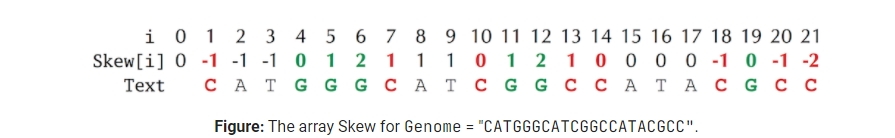

In [20]:
def MinimumSkew(Genome):
    """Input  : string
       Output : list
       
       Find all positions in a sequence where a minimum array skew emerges (that is, more 'C's compared to 'G's )"""

    Positions = []
    array = SkewArray(Genome)
    min_array = min(array)
    for index, number in enumerate (array):
        if number == min_array :
            Positions.append(index)
    return Positions

# Remarks : We merely starting scanning from position 0 in the sequence, which isn't necessarily position 0 in the genome. 
# Hence, we need to translate the relative positions of the nucleotides to absolute positions in the genome too.


In [21]:
def ApproximatePatternMatching(Sequence, kmer, d):
    """Input 1: String 
       Input 2: String 
       Input 3: int  (maximum allowed hammington distance between k-mers)
       Output: A list containing all starting positions where Pattern appears
       
       Scan through a sequence and check where a particular kmer (or a kmer that differs only by 'd' bases) occurs """
    
    start_match = []                                                       #indexes where kmers start to emerge 
    ham_dist    = 0 
    
    for index in range(len(Sequence)-len(kmer)+1):
        
        Sequence_piece = Sequence[index:index+len(kmer)]
        ham_dist = sum(1 for k, j in zip(Sequence_piece,kmer) if k != j)
        
        if ham_dist <= d :
            start_match.append(index)
            
    return start_match 